### Load in Data

In [5]:
import pandas as pd
import glob

# Get a list of all cringe csv files
cringe_list = glob.glob('Dataset(.csv)/CringeData/*.csv')
cringe_list_size = len(cringe_list)

# Initalize dataframe which will hold mergedcsv files
cringeDF = pd.DataFrame()

# Go through list and give each file a videoID and label of 0
for i in range(0, cringe_list_size):
    tempDF = pd.read_csv(cringe_list[i])
    tempDF['video_id'] = str(i) + 'c'
    tempDF['label'] = 0
    
    # Merge file into cringeDF
    cringeDF= cringeDF.append(tempDF, sort=True)
    
    # Reset index
    cringeDF.reset_index()

    
# Get a list of all pain csv files
disgust_list = glob.glob('Dataset(.csv)/disgustData/*.csv')
disgust_list_size = len(disgust_list)

# Initialize dataframe which will hold merged csv files
disgustDF = pd.DataFrame()

# Go through list and give each file a videoID and label of 1
for i in range(0, disgust_list_size):
    tempDF = pd.read_csv(disgust_list[i])
    tempDF['video_id'] = str(i) + 'd'
    tempDF['label'] = 1
    
    # Merge file into cringeDF
    disgustDF= disgustDF.append(tempDF, sort=True)
    
    # Reset index
    disgustDF.reset_index()
            

### Clean Data 

In [12]:
from sklearn.preprocessing import StandardScaler

# Filter out unsuccessful and low confidence frames
cringeDF = cringeDF.loc[cringeDF['confidence'] > 0.8]
cringeDF = cringeDF.loc[cringeDF['success'] == 1]

#print(pd.DataFrame(lst))
disgustDF = disgustDF.loc[disgustDF['confidence'] > 0.8] 
disgustDF = disgustDF.loc[disgustDF['success'] == 1]

# # Merge all csv entries and all cols
combinedDF = cringeDF.append(disgustDF, sort= True)
combinedDF = combinedDF.reset_index()



### View AU Intensity Differences

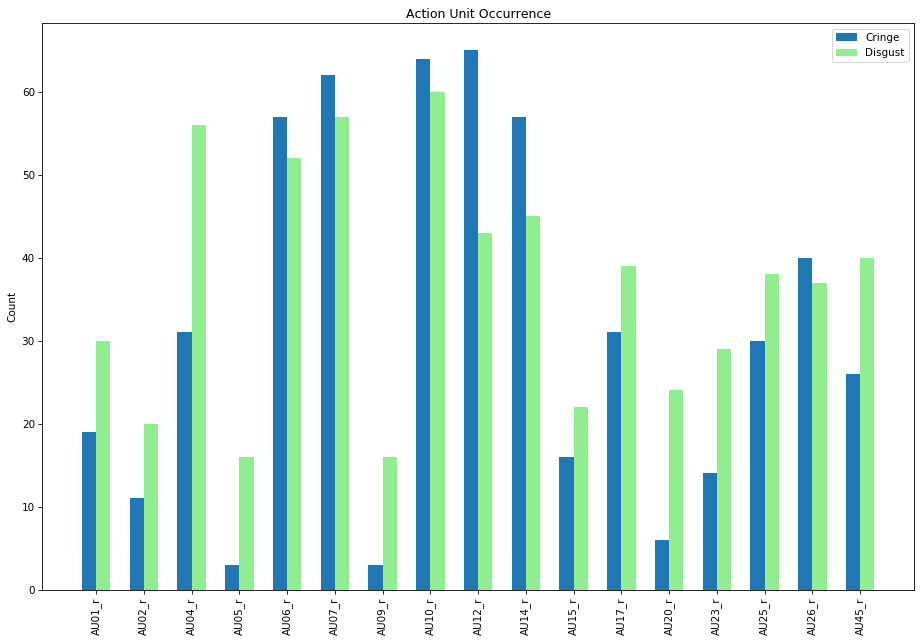

In [9]:
import numpy as np
import matplotlib.pyplot as plt
# Inspiration from https://www.youtube.com/watch?v=l11iy6SSUCY&ab_channel=SFURosieLab
# Get the max AU intenisty per AU per video
feature_list = ['AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r',
                'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r',
                'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r', 'video_id']

cringeFeaturesDF = cringeDF.loc[:,feature_list]
disgustFeaturesDF = disgustDF.loc[:,feature_list]

# Get max AU intensity for each video
cringeMaxAU = cringeFeaturesDF.groupby('video_id').max()
disgustMaxAU = disgustFeaturesDF.groupby('video_id').max() 

# Total number of times the AU was above 2
cringeAUs = (cringeMaxAU > 1).sum()
disgustAUs = (disgustMaxAU > 1).sum()

# Set our x axis 
x1 = cringeAUs.index

# Get counts for each type of expression
y1 = cringeAUs.values
y2 = disgustAUs.values 

ind = np.arange(cringeAUs.index.size)
width = 0.3
# Plot figure, bars, ticks and legend
plt.figure(num=1, figsize=(15,10),dpi=75)
p1 = plt.bar(ind,y1, width = width, label = 'Cringe')
plt.xticks(rotation = 90)
p2 = plt.bar(ind+width,y2, width = width, color='lightgreen', label = 'Disgust')
plt.ylabel('Count')
plt.title('Action Unit Occurrence')
plt.xticks(ind + width / 2, x1)
plt.legend(loc='best')
plt.show()


### Group by Frames and Split Data

In [17]:
from sklearn.model_selection import train_test_split

# Only select AU intensities
important_features = ['AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r',
                      'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r',
                      'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r']

cringeAU_DF = cringeDF.loc[:,important_features]
disgustAU_DF = disgustDF.loc[:,important_features]

# Get video ID separately
cringe_videos = cringeDF['video_id']
cringe_videos_list = cringe_videos.to_numpy()

disgust_videos = disgustDF['video_id']
disgust_videos_list = disgust_videos.to_numpy()


# Standardize data
standardScaler = StandardScaler()

cringeFeaturesDF = standardScaler.fit_transform(cringeAU_DF)
cringeFeaturesDF = pd.DataFrame(cringeFeaturesDF)
cringeFeaturesDF['video_id'] = cringe_videos_list


disgustFeaturesDF = standardScaler.fit_transform(disgustAU_DF)
disgustFeaturesDF = pd.DataFrame(disgustFeaturesDF)
disgustFeaturesDF['video_id']= disgust_videos_list


# Group Frames
cringeFeaturesList = []

for video in cringeFeaturesDF['video_id'].unique():
    
    frame_length = len(cringeFeaturesDF[cringeFeaturesDF['video_id'] == video].drop(['video_id'], axis=1).to_numpy())
    
    # Add a copy of the first frame in case frames are less than 30
    if(frame_length < 30):
        first_result = cringeFeaturesDF[cringeFeaturesDF['video_id'] == video].head(1)
        difference = 30 - frame_length
        for i in range(difference+1):
            cringeFeaturesDF = cringeFeaturesDF.append(first_result)
    
    cringeFeaturesList.append(cringeFeaturesDF[cringeFeaturesDF['video_id'] == video].drop(['video_id'], axis=1).to_numpy())
    
            
cringeFeaturesList = np.array(cringeFeaturesList)

disgustFeaturesList = []

for video in disgustFeaturesDF['video_id'].unique():
    frame_length = len(disgustFeaturesDF[disgustFeaturesDF['video_id'] == video].to_numpy())
    
    # Add a copy of the first frame in case frames are less than 30
    if(frame_length < 30):
        first_result = disgustFeaturesDF[disgustFeaturesDF['video_id'] == video].head(1)
        difference = 30 - frame_length
        for i in range(difference+1):
            disgustFeaturesDF = disgustFeaturesDF.append(first_result)
    
    disgustFeaturesList.append(disgustFeaturesDF[disgustFeaturesDF['video_id'] == video].drop(['video_id'], axis=1).to_numpy())

disgustFeaturesList = np.array(disgustFeaturesList)

# Combine the data
X = np.concatenate([cringeFeaturesList, disgustFeaturesList])

y = np.concatenate([np.ones(disgustFeaturesList.shape[0]), np.zeros(cringeFeaturesList.shape[0])])

# Split into train and test data
X_train, X_test, train_labels, test_labels = train_test_split(X, y, test_size = 0.2)

# Make the length of each frame the same to 30 frames
# 60 was chosen based off of calculating average length of frames
for i in range(len(X_train)):
    if(len(X_train[i]) > 30):
        X_train[i] = X_train[i][0:30]
        
for i in range(len(X_test)):
    if(len(X_test[i]) > 30):
        X_test[i] = X_test[i][0:30]
        
# Reshape
X_train = X_train.tolist()
X_test = X_test.tolist()

X_train = np.array(X_train)
X_test = np.array(X_test)

train_samples, xlen, ylen = X_train.shape
X_train = X_train.reshape((train_samples,xlen*ylen))

test_samples, xt, yt = X_test.shape
X_test = X_test.reshape((test_samples,xt*yt))

    

### Use PCA for Visualization

In [18]:
from sklearn.decomposition import PCA

# Initialize PCA and choose number of components to keep
pca = PCA(n_components=2)

# Conduct PCA to reduce to two components
reducedDimensions = pca.fit_transform(X_train)

print("The explained variance of two components: ", pca.explained_variance_ratio_) 

# Create a df of the two components
pcaDF = pd.DataFrame(data = reducedDimensions, columns = ['principal component 1', 'principal component 2'])
pcaDF

The explained variance of two components:  [0.17383232 0.09902142]


,principal component 1,principal component 2
0,-12.985953,-3.841053
1,20.646931,1.733114
2,-6.704219,-7.750720
3,-14.120525,1.193792
4,-3.213794,-3.556129
...,...,...
113,7.614755,-2.287756
114,8.508808,-5.546998
115,-2.501224,-5.298571
116,16.683244,-1.908738


### GMM Covariance Selection

In [19]:
# Using scikit-learn code from: 
# https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py

from sklearn import mixture

X = pcaDF
lowest_bic = np.infty
bic = []
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    # Fit a Gaussian mixture with EM
    gmm = mixture.GaussianMixture(
        n_components=2, covariance_type=cv_type
    )
    gmm.fit(X)
    bic.append(gmm.bic(X))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm = cv_type
        
print("The best covariance for k=2 is:",best_gmm)


The best covariance for k=2 is: diag


### GMM Clustering Visualization

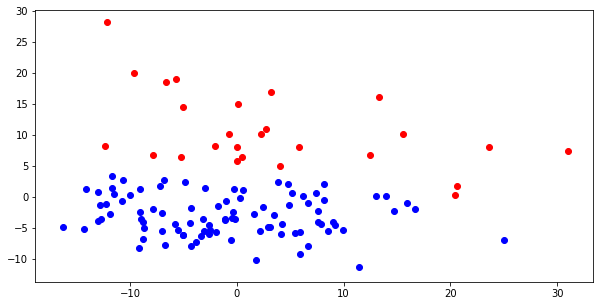

In [21]:
gmm = mixture.GaussianMixture(
        n_components=2, covariance_type="diag"
    )
gmm.fit(X)
labels = gmm.predict(X)

#filter rows of original data (https://www.askpython.com/python/examples/plot-k-means-clusters-python)
filtered_label0 = pcaDF[labels == 0]
filtered_label1 = pcaDF[labels == 1]

#Plotting the results (https://www.askpython.com/python/examples/plot-k-means-clusters-python)
plt.figure(figsize=(10, 5))
plt.scatter(filtered_label0['principal component 1'] , filtered_label0['principal component 2'], color = 'red')
plt.scatter(filtered_label1['principal component 1'] , filtered_label1['principal component 2'] , color = 'blue')


### SVM Cross-Validation

In [181]:
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
import sys

# Initialize arrays to keep track of performance
svm_accuracy = []
svm_recall = []
svm_precision = []
svm_f1scores = []
svm_confusion_matrices = []

kfold = StratifiedKFold(5, True, 1)

# Conduct 5-fold cross-validation
for train_index, test_index in kfold.split(X_train, train_labels):
    # Reset model 
    # kernel, C and gamma were chosen based on accuracy trial and error 
    model = svm.SVC(C=10, kernel='rbf', decision_function_shape='ovo', gamma='auto') 
    
    # Get training data and test data
    train_data, test_data = X_train[train_index], X_train[test_index]
    
    # Convert to np array to get correct shape
    train_data = train_data.tolist()
    train_data = np.array(train_data)
    
    test_data = test_data.tolist()
    test_data = np.array(test_data)
    
    # Reshape
    nsamples, nx, ny = train_data.shape
    train_data = train_data.reshape((nsamples,nx*ny))
    
    tnsamples, tnx, tny = test_data.shape
    test_data = test_data.reshape((tnsamples,tnx*tny))
    
    # Source ground truth labels
    actual_train_labels = train_labels[train_index]
    actual_test_labels = train_labels[test_index]
    np.set_printoptions(threshold=sys.maxsize)

    # Fit and predict
    model.fit(train_data.tolist(), actual_train_labels)
    svm_labels = model.predict(test_data)
    
    # Calculate accuracy, recall, precision, and f1 scores
    svm_accuracy_score = metrics.accuracy_score(actual_test_labels, svm_labels)
    svm_recall_score = metrics.recall_score(actual_test_labels, svm_labels, average="macro")
    svm_precision_score = metrics.precision_score(actual_test_labels, svm_labels, average="macro")
    svm_f1_score = metrics.f1_score(actual_test_labels, svm_labels, average="macro")
    
    # Store the results in respective arrays
    svm_accuracy.append(svm_accuracy_score)
    svm_recall.append(svm_recall_score)
    svm_precision.append(svm_precision_score)
    svm_f1scores.append(svm_f1_score)
    svm_confusion_matrices.append(np.asarray(metrics.confusion_matrix(actual_test_labels, svm_labels)))

### Performance of Cross-Validation

The average accuracy score is:  0.5943019943019943
The average recall score is:  0.593956043956044
The average precision score is:  0.5957238594738594
The average f1 score is:  0.5920512820512821


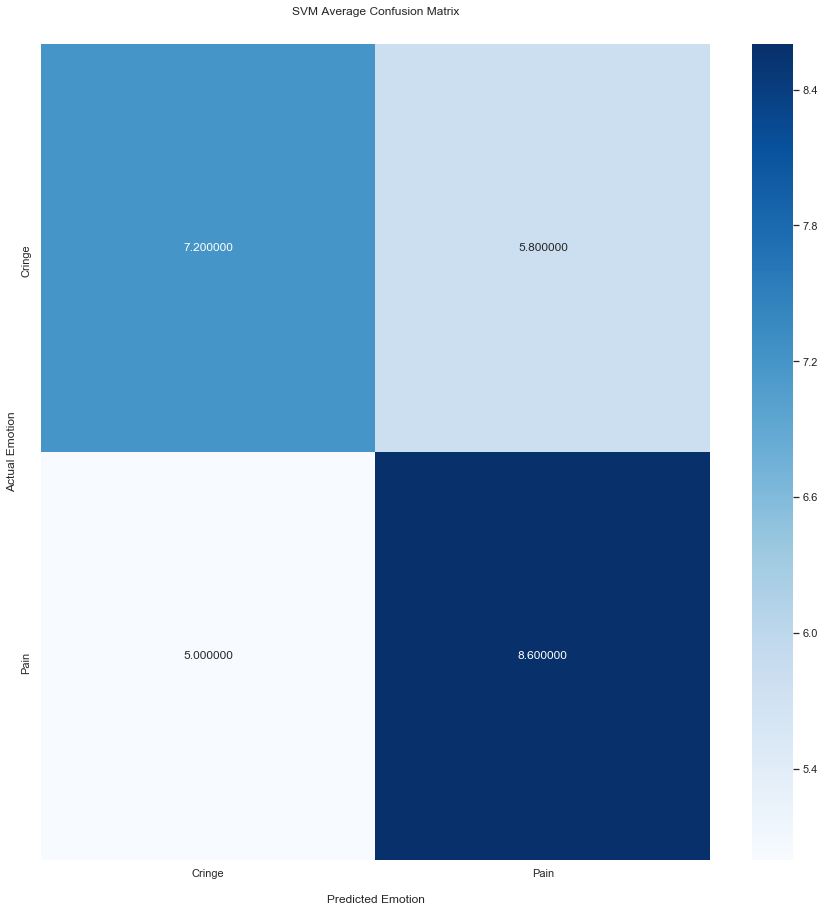

In [182]:
# https://seaborn.pydata.org/#:~:text=Seaborn%20is%20a%20Python%20data,introductory%20notes%20or%20the%20paper.
# https://docs.python.org/3/library/statistics.html
# https://matplotlib.org/
import statistics
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate average scores 
average_svm_accuracy = statistics.mean(svm_accuracy)
average_svm_recall = statistics.mean(svm_recall)
average_svm_precision = statistics.mean(svm_precision)
average_svm_f1 = statistics.mean(svm_f1scores)

# Output average scores
print("The average accuracy score is: ", average_svm_accuracy)
print("The average recall score is: ", average_svm_recall)
print("The average precision score is: ", average_svm_precision)
print("The average f1 score is: ", average_svm_f1)

# Initialize a 7x7 2D array for getting CM average
summed_svm_cm = np.zeros(4).reshape(2,2)

# Sum values of matrix for getting CM average
for matrix in svm_confusion_matrices: 
    summed_svm_cm = np.add(summed_svm_cm, matrix)

average_svm_cm = np.divide(summed_svm_cm, 5) 
matrix_labels = ["Cringe", "Pain"]

# Code below used from https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/#:~:text=import%20seaborn%20as%20sns%0Aimport,the%20Confusion%20Matrix.%0Aplt.show()
sns.set(rc = {'figure.figsize':(15,15)})
ax = sns.heatmap(average_svm_cm, fmt="f", annot=True, cmap='Blues')

ax.set_title('SVM Average Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Emotion')
ax.set_ylabel('Actual Emotion');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(matrix_labels)
ax.yaxis.set_ticklabels(matrix_labels)

# fix for mpl bug that cuts off top/bottom of seaborn viz https://github.com/mwaskom/seaborn/issues/1773
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
## Display the visualization of the Confusion Matrix.
plt.show()

### Test Performance

The accuracy score is:  0.47058823529411764
The recall score is:  0.4642857142857143
The precision score is:  0.4652777777777778
The F1 score is:  0.4631578947368421


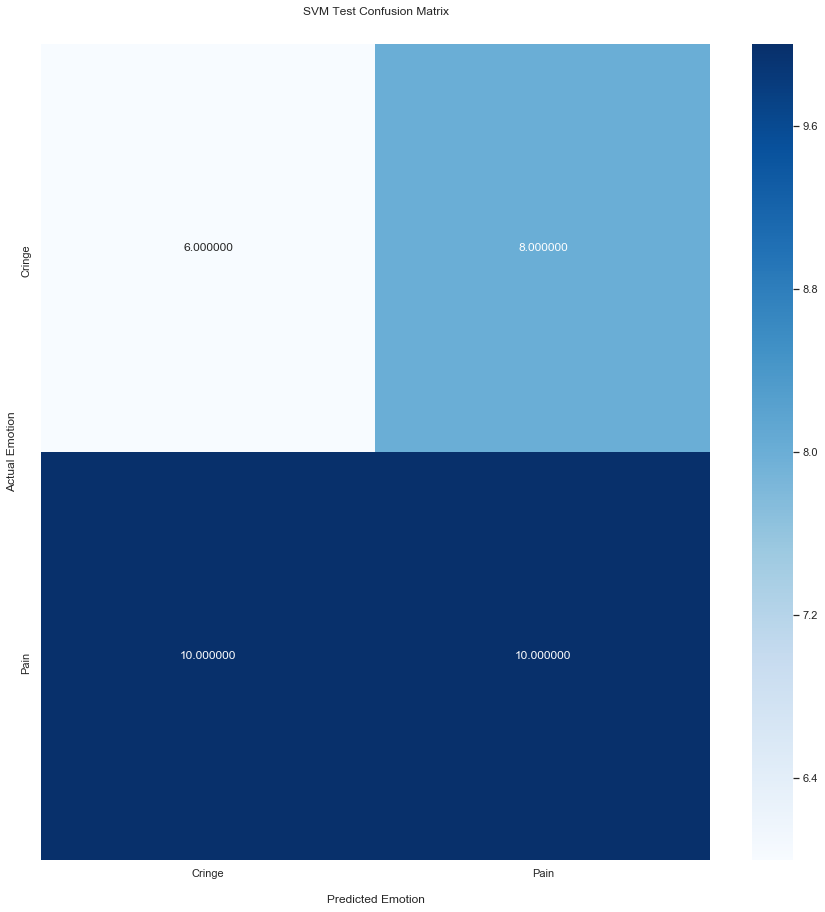

In [186]:
# Performance on Test Data
model = svm.SVC(C=10, kernel='rbf', decision_function_shape='ovo', gamma='auto')

# Reshape
X_train = X_train.tolist()
X_test = X_test.tolist()

X_train = np.array(X_train)
X_test = np.array(X_test)

train_samples, xlen, ylen = X_train.shape
X_train = X_train.reshape((train_samples,xlen*ylen))

test_samples, xt, yt = X_test.shape
X_test = X_test.reshape((test_samples,xt*yt))

model.fit(X_train, train_labels)
results = model.predict(X_test)

test_accuracy = metrics.accuracy_score(test_labels, results)
test_recall = metrics.recall_score(test_labels, results, average="macro")
test_precision = metrics.precision_score(test_labels, results, average="macro")
test_f1score =  metrics.f1_score(test_labels, results, average="macro")
test_confusion = metrics.confusion_matrix(test_labels, results)

print("The accuracy score is: ", test_accuracy)
print("The recall score is: ", test_recall)
print("The precision score is: ", test_precision)
print("The F1 score is: ", test_f1score)
# Code below used from https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/#:~:text=import%20seaborn%20as%20sns%0Aimport,the%20Confusion%20Matrix.%0Aplt.show()
sns.set(rc = {'figure.figsize':(15,15)})
ax = sns.heatmap(test_confusion, fmt="f", annot=True, cmap='Blues')

ax.set_title('SVM Test Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Emotion')
ax.set_ylabel('Actual Emotion');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(matrix_labels)
ax.yaxis.set_ticklabels(matrix_labels)

# fix for mpl bug that cuts off top/bottom of seaborn viz https://github.com/mwaskom/seaborn/issues/1773
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
## Display the visualization of the Confusion Matrix.
plt.show()